# Industrial Defect Inspection with image segmentation

In order to satisfy customers' needs, companies have to guarantee the quality of their products, which can often be achieved only by inspection of the finished product. Automatic visual defect detection has the potential to reduce the cost of quality assurance significantly.

## Data description

[`29th Annual Symposium of the German Association for Pattern Recognition, Weakly Supervised Learning for Industrial Optical Inspection, 2007.`](http://resources.mpi-inf.mpg.de/conferences/dagm/2007/prizes.html)

This dataset is artificially generated, but similar to real world problems. It consists of multiple data sets, each consisting of 1000 images showing the background texture without defects, and of 150 images with one labeled defect each on the background texture. The images in a single data set are very similar, but each data set is generated by a different texture model and defect model.

Not all deviations from the texture are necessarily defects. The algorithm will need to use the weak labels provided during the training phase to learn the properties that characterize a defect.

Below are sample images from 6 data sets. In these examples, defects are weakly labeled by a surrounding ellipse, shown in red. 

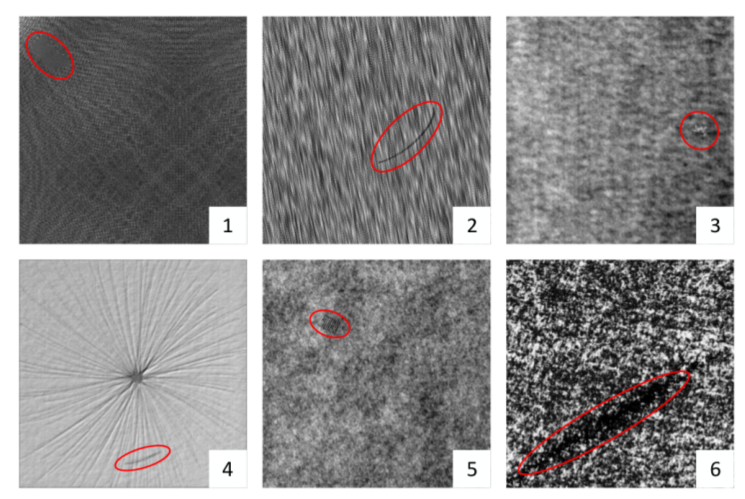

In [1]:
from IPython.display import Image
import os
%matplotlib inline
Image('./userdata/WeaklySpervisedLearningforIndustrialOpticalInspection.jpg')

### labeling data

Defect exists inside an image was bounded with an ellipse. The ellipse-parameters are provided in a separate .txt-file with a format as shown below. 

[filename] \t \n
[semi-major axis] \t [semi-minor axis] \t [rotation angle] \t
[x-position of the centre of the ellipsoid] \t [y-position of the centre of the ellipsoid] \n
[filename] \t ... 

In [2]:
!cat '/data/examples/NV_public_defects/Class1_def/labels.txt'

1	  60.24	  37.55	   0.65	  69.04	  87.60
2	  41.34	  35.83	   0.37	 315.40	 172.29
3	  53.98	  40.30	   1.53	 110.97	 170.01
4	  63.41	  53.70	   1.50	 253.14	  65.83
5	  71.81	  42.12	   0.62	 151.85	 312.05
6	  66.19	  64.12	   1.29	 143.03	 352.48
7	  47.17	  50.18	   0.20	  54.54	 255.97
8	  36.36	  40.48	   0.35	  42.06	 244.56
9	  63.10	  37.97	  -1.00	 119.86	 100.36
10	  56.80	  37.49	  -0.04	  61.46	 339.66
11	  66.00	  45.08	   0.62	  71.50	  69.96
12	  68.91	  67.24	   2.41	 304.37	  91.09
13	  72.10	  82.92	   0.43	  62.86	 309.99
14	  51.99	  31.63	   0.66	 177.53	 127.98
15	  40.41	  36.32	   0.20	  87.91	 204.41
16	  83.71	  94.96	  -0.20	 156.56	 226.52
17	  56.22	  41.54	   1.51	  91.71	  92.24
18	  78.04	  82.53	  -0.81	 115.38	 177.33
19	  65.82	  28.70	  -0.74	  88.24	 158.84
20	  50.15	  58.30	  -1.70	  47.76	  60.01
21	  41.31	  30.48	  -0.57	  74.38	 351.65
22	  86.50	  89.55	  -1.39	 128.53	 338.77
23	  80.56	  46.61	  -0.18	  77.91	  49.65
24	  82.93	  55.43	 

## Data Preprocessing/Exploration/Inspection

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
! pip install --user xmltodict

Using TensorFlow backend.


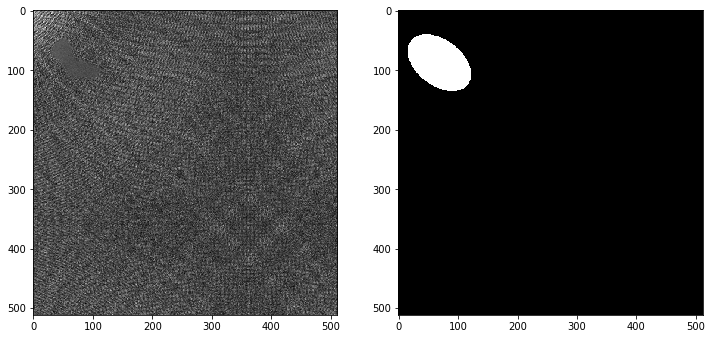

In [4]:
from coslib.Plot import plot_ellipse_seg_test
d_dataset = "/data/examples/NV_public_defects/"
plot_ellipse_seg_test(d_dataset + '/Class1_def/1.png')

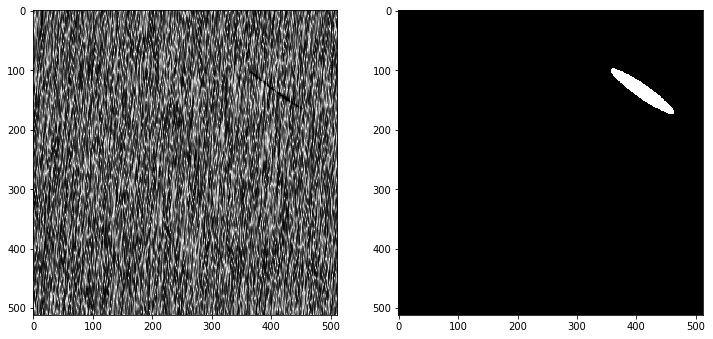

In [5]:
plot_ellipse_seg_test(d_dataset + '/Class2_def/1.png')

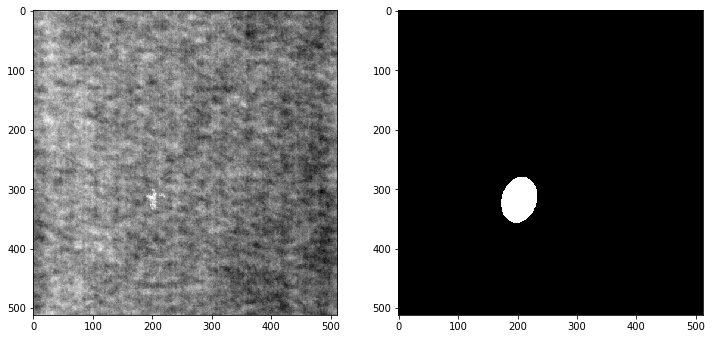

In [6]:
plot_ellipse_seg_test(d_dataset + '/Class3_def/1.png')

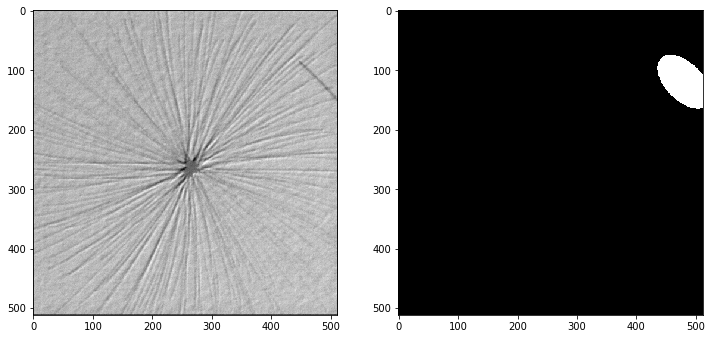

In [7]:
plot_ellipse_seg_test(d_dataset + '/Class4_def/3.png')

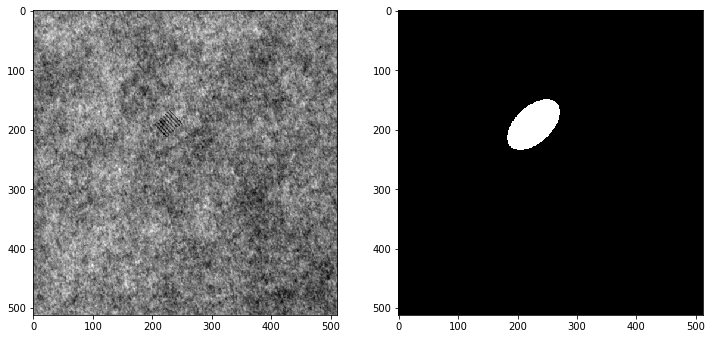

In [8]:
plot_ellipse_seg_test(d_dataset + '/Class5_def/1.png')

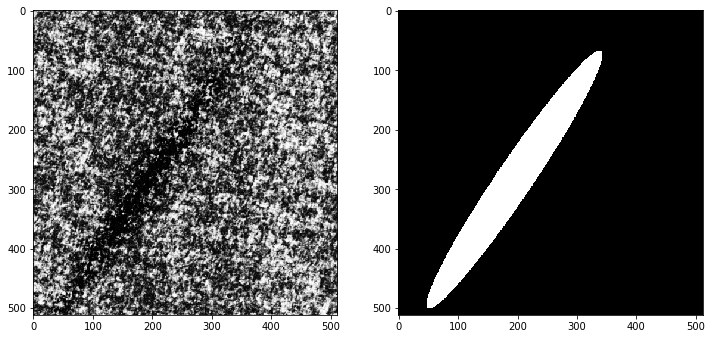

In [9]:
plot_ellipse_seg_test(d_dataset + '/Class6_def/50.png')

In [11]:
from coslib.DataIO import load_images_masks
X, y = load_images_masks(d_dataset + '/Class1_def/', img_type='png', img_format='gray', resize=(512, 512), ellipse=True)

In [12]:
X.shape

(150, 512, 512, 1)

In [13]:
y.shape

(150, 512, 512, 1)

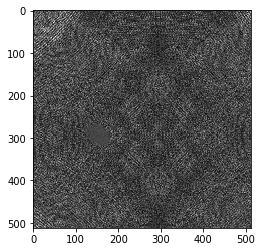

In [14]:
plt.imshow(X[0,:,:,0], cmap='gray')

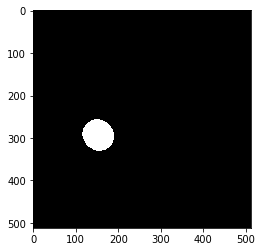

In [15]:
plt.imshow(y[0,:,:,0], cmap='gray')

In [16]:
import sklearn

In [17]:
sklearn.__version__

'0.19.1'

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [21]:
X_train.shape

(105, 512, 512, 1)

In [22]:
X_test.shape

(45, 512, 512, 1)

## Unet - Fully Convolutional Neuralnetwork

The u-net is convolutional network architecture for fast and precise segmentation of images. Up to now it has outperformed the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin.

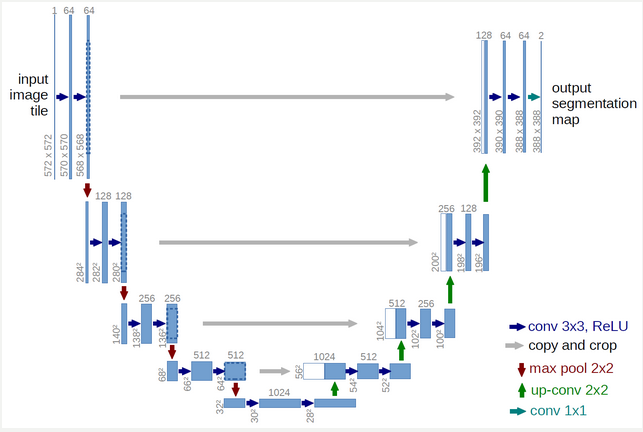

In [24]:
Image('./userdata/Unet-model.jpg')

In [25]:
img_rows = 512
img_cols = 512

In [26]:
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D,Lambda, Conv2DTranspose, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from scipy.ndimage.measurements import label
import time

In [27]:
### Defining a small Unet
### Smaller Unet defined so it fits in memory

def get_small_unet():
    inputs = Input((img_rows, img_cols,1))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(16, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(8, kernel_size=(2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    
    return model

In [28]:
model = get_small_unet()

In [29]:
### IOU or dice coeff calculation
def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [30]:
smooth = 1.
model.compile(optimizer=Adam(lr=1e-4), loss=IOU_calc_loss, metrics=[IOU_calc])

In [31]:
history = model.fit(X_train, y_train, batch_size=10, epochs=50, verbose=1, validation_split=0.1)

Train on 94 samples, validate on 11 samples
Epoch 1/50
94/94 [==============================] - 18s 188ms/step - loss: -0.0769 - IOU_calc: 0.0769 - val_loss: -0.0678 - val_IOU_calc: 0.0678
Epoch 2/50
94/94 [==============================] - 2s 26ms/step - loss: -0.0802 - IOU_calc: 0.0802 - val_loss: -0.0703 - val_IOU_calc: 0.0703
Epoch 3/50
94/94 [==============================] - 2s 26ms/step - loss: -0.0827 - IOU_calc: 0.0827 - val_loss: -0.0730 - val_IOU_calc: 0.0730
Epoch 4/50
94/94 [==============================] - 2s 26ms/step - loss: -0.0856 - IOU_calc: 0.0856 - val_loss: -0.0771 - val_IOU_calc: 0.0771
Epoch 5/50
94/94 [==============================] - 2s 26ms/step - loss: -0.0906 - IOU_calc: 0.0906 - val_loss: -0.0849 - val_IOU_calc: 0.0849
Epoch 6/50
94/94 [==============================] - 2s 27ms/step - loss: -0.1006 - IOU_calc: 0.1006 - val_loss: -0.1046 - val_IOU_calc: 0.1046
Epoch 7/50
94/94 [==============================] - 2s 26ms/step - loss: -0.1292 - IOU_calc: 0.1

## Learning curves

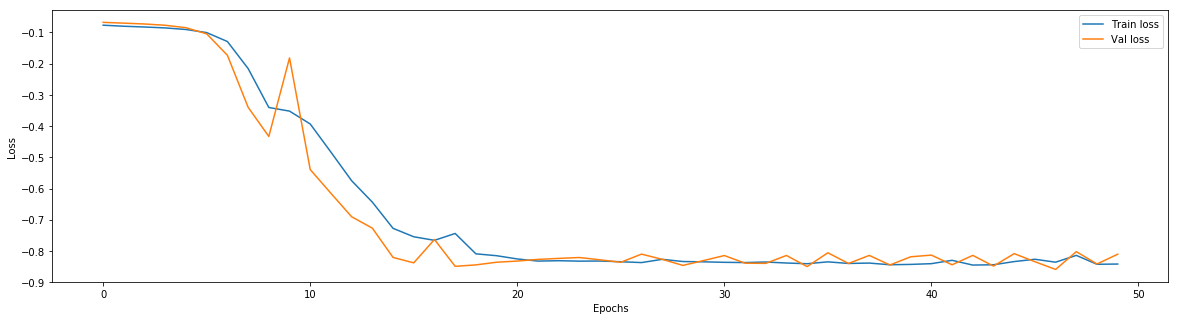

In [32]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['loss'], label='Train loss')
plt.plot(model.history.history['val_loss'], label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

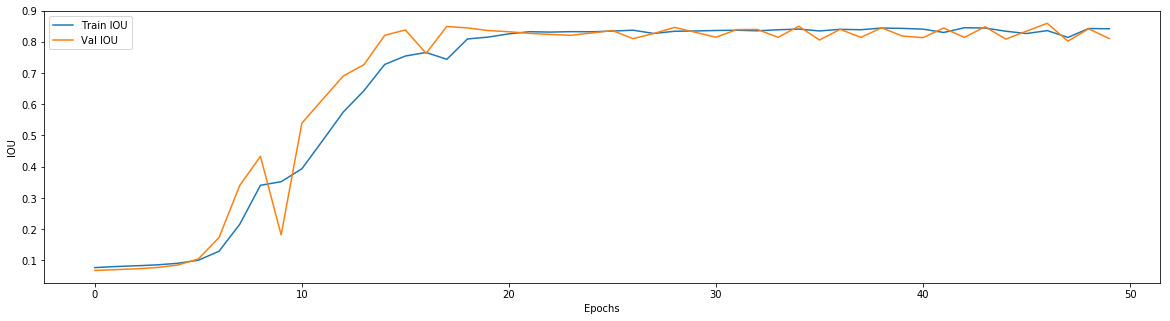

In [33]:
plt.figure(figsize=(20, 5))
plt.plot(model.history.history['IOU_calc'], label='Train IOU')
plt.plot(model.history.history['val_IOU_calc'], label='Val IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()

## Predict on testing data

In [34]:
predict = model.predict(X_test)

In [35]:
import numpy as np
import cv2
def predict_evaluation(pred, image, label):
    '''
    '''
    # transform gray image to rgb
    img = np.array(image, np.uint8)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    # scale pred and mask's pixel range to 0~255
    im_label = np.array(255*label, dtype=np.uint8)
    im_pred = np.array(255*pred, dtype=np.uint8)
    
    # transform both of them to rgb
    rgb_label = cv2.cvtColor(im_label, cv2.COLOR_GRAY2RGB)
    rgb_pred = cv2.cvtColor(im_pred, cv2.COLOR_GRAY2RGB)
    
    rgb_label[:,:,1:3] = 0*rgb_label[:,:,1:2]
    rgb_pred[:,:,0] = 0*rgb_pred[:,:,0]
    rgb_pred[:,:,2] = 0*rgb_pred[:,:,2]
    
    img_pred = cv2.addWeighted(rgb_img, 1, rgb_pred, 0.3, 0)
    img_label = cv2.addWeighted(rgb_img, 1, rgb_label, 0.3, 0)
    
    plt.figure(figsize=(10, 10))
    
    plt.subplot(1,3,1)
    plt.imshow(rgb_img)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Prediction')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_label)
    plt.title('Ground truth')
    plt.axis('off')

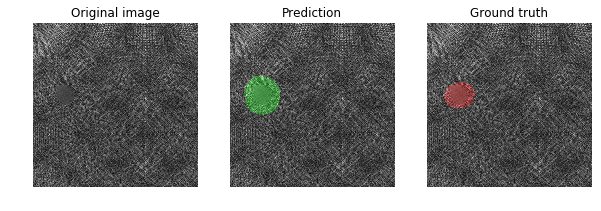

In [36]:
predict_evaluation(predict[0,:,:,0], X_test[0,:,:,0], y_test[0,:,:,0])

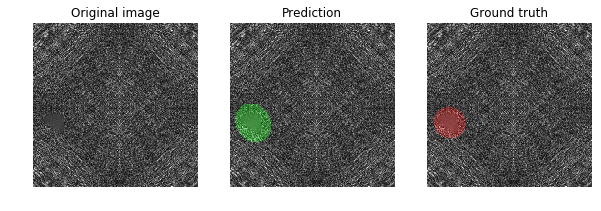

In [37]:
predict_evaluation(predict[1,:,:,0], X_test[1,:,:,0], y_test[1,:,:,0])

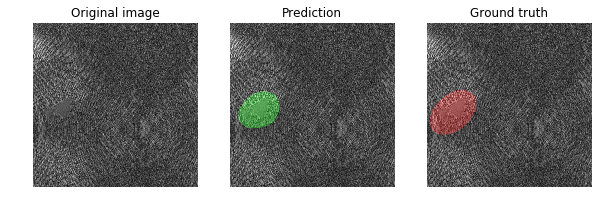

In [38]:
predict_evaluation(predict[2,:,:,0], X_test[2,:,:,0], y_test[2,:,:,0])

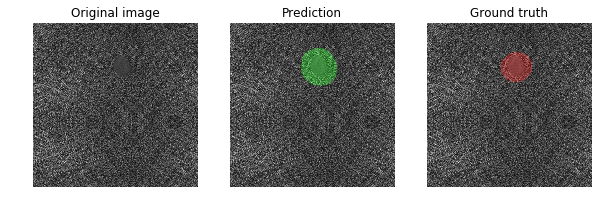

In [39]:
predict_evaluation(predict[3,:,:,0], X_test[3,:,:,0], y_test[3,:,:,0])

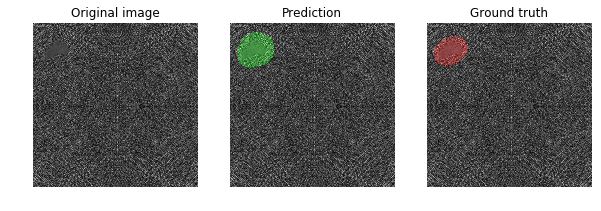

In [40]:
predict_evaluation(predict[4,:,:,0], X_test[4,:,:,0], y_test[4,:,:,0])

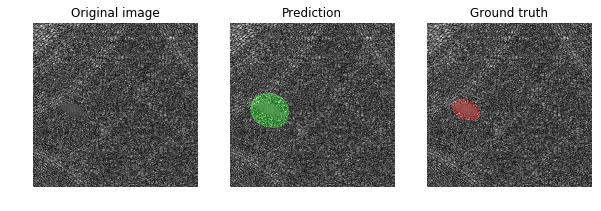

In [41]:
predict_evaluation(predict[5,:,:,0], X_test[5,:,:,0], y_test[5,:,:,0])

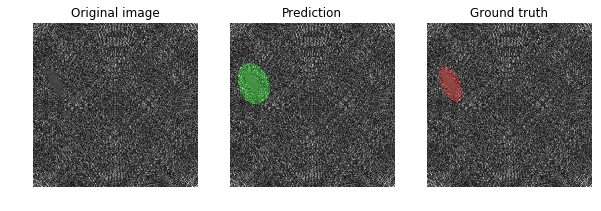

In [42]:
predict_evaluation(predict[6,:,:,0], X_test[6,:,:,0], y_test[6,:,:,0])

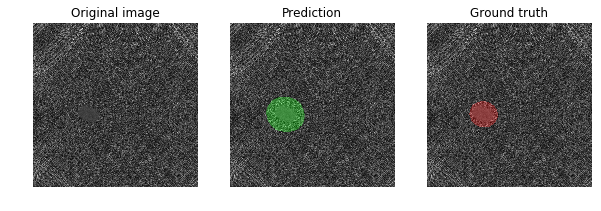

In [43]:
predict_evaluation(predict[7,:,:,0], X_test[7,:,:,0], y_test[7,:,:,0])

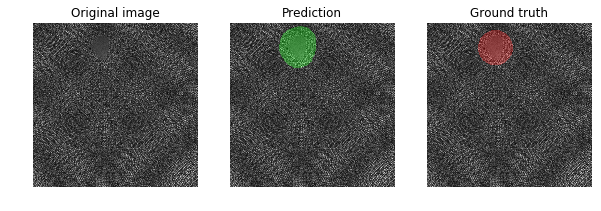

In [44]:
predict_evaluation(predict[8,:,:,0], X_test[8,:,:,0], y_test[8,:,:,0])

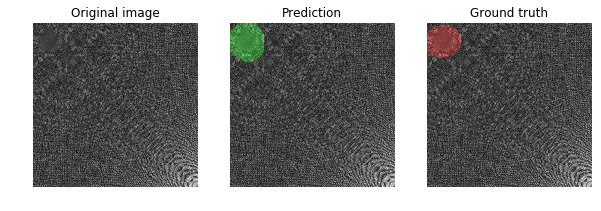

In [45]:
predict_evaluation(predict[9,:,:,0], X_test[9,:,:,0], y_test[9,:,:,0])

## Save model for later use

In [46]:
model_json_string = model.to_json()

In [47]:
with open('./userdata/model.json', 'w') as f:
    f.write(model_json_string)

In [48]:
model.save_weights('./userdata/model.h5')

In [49]:
!ls ./userdata/

CNN.png		   model.h5
context-aware.png  model.json
FCN.jpg		   operationFCN.png
IOU.png		   Unet-model.jpg
lung_nodule.png    WeaklySpervisedLearningforIndustrialOpticalInspection.jpg


In [50]:
from coslib.ModelIO import convert_keras_to_pb

In [51]:
convert_keras_to_pb('./userdata/', 'conv2d_19/Sigmoid')

INFO:tensorflow:Restoring parameters from ./userdata/saved_checkpoint-0
INFO:tensorflow:Froze 46 variables.
Converted 46 variables to const ops.


In [52]:
!ls ./userdata/

checkpoint_state   model.json
CNN.png		   operationFCN.png
context-aware.png  output_graph.pb
FCN.jpg		   saved_checkpoint-0.data-00000-of-00001
input_graph.pb	   saved_checkpoint-0.index
IOU.png		   saved_checkpoint-0.meta
lung_nodule.png    Unet-model.jpg
model.h5	   WeaklySpervisedLearningforIndustrialOpticalInspection.jpg
